In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.rcParams['figure.dpi'] = 300
from collections import namedtuple

In [2]:
# Create a namedtuple that contains parameters
MoneySupplyModel = namedtuple("MoneySupplyModel", 
                        ["γ1", "γ2", "g", 
                         "M0", "R_u", "R_l"])

def create_model(γ1=100, γ2=50, g=3.0, M0=100):
    
    # Calculate the steady states for R
    R_steady = np.roots((-γ1, γ1 + γ2 - g, -γ2))
    R_u, R_l = R_steady
    print("[R_u, R_l] =", R_steady)
    
    return MoneySupplyModel(γ1=γ1, γ2=γ2, g=g, M0=M0, R_u=R_u, R_l=R_l)

In [3]:
def seign(R, model):
    γ1, γ2, g = model.γ1, model.γ2, model.g
    return -γ2/R + (γ1 + γ2)  - γ1 * R

msm = create_model()

# Calculate initial guess for p0
p0_guess = msm.M0 / (msm.γ1 - msm.g - msm.γ2 / msm.R_u)
print(f'p0 guess = {p0_guess:.4f}')

# Calculate seigniorage maximizing rate of return
R_max = np.sqrt(msm.γ2/msm.γ1)
g_max = seign(R_max, msm)
print(f'R_max, g_max = {R_max:.4f}, {g_max:.4f}')

[R_u, R_l] = [0.93556171 0.53443829]
p0 guess = 2.2959
R_max, g_max = 0.7071, 8.5786


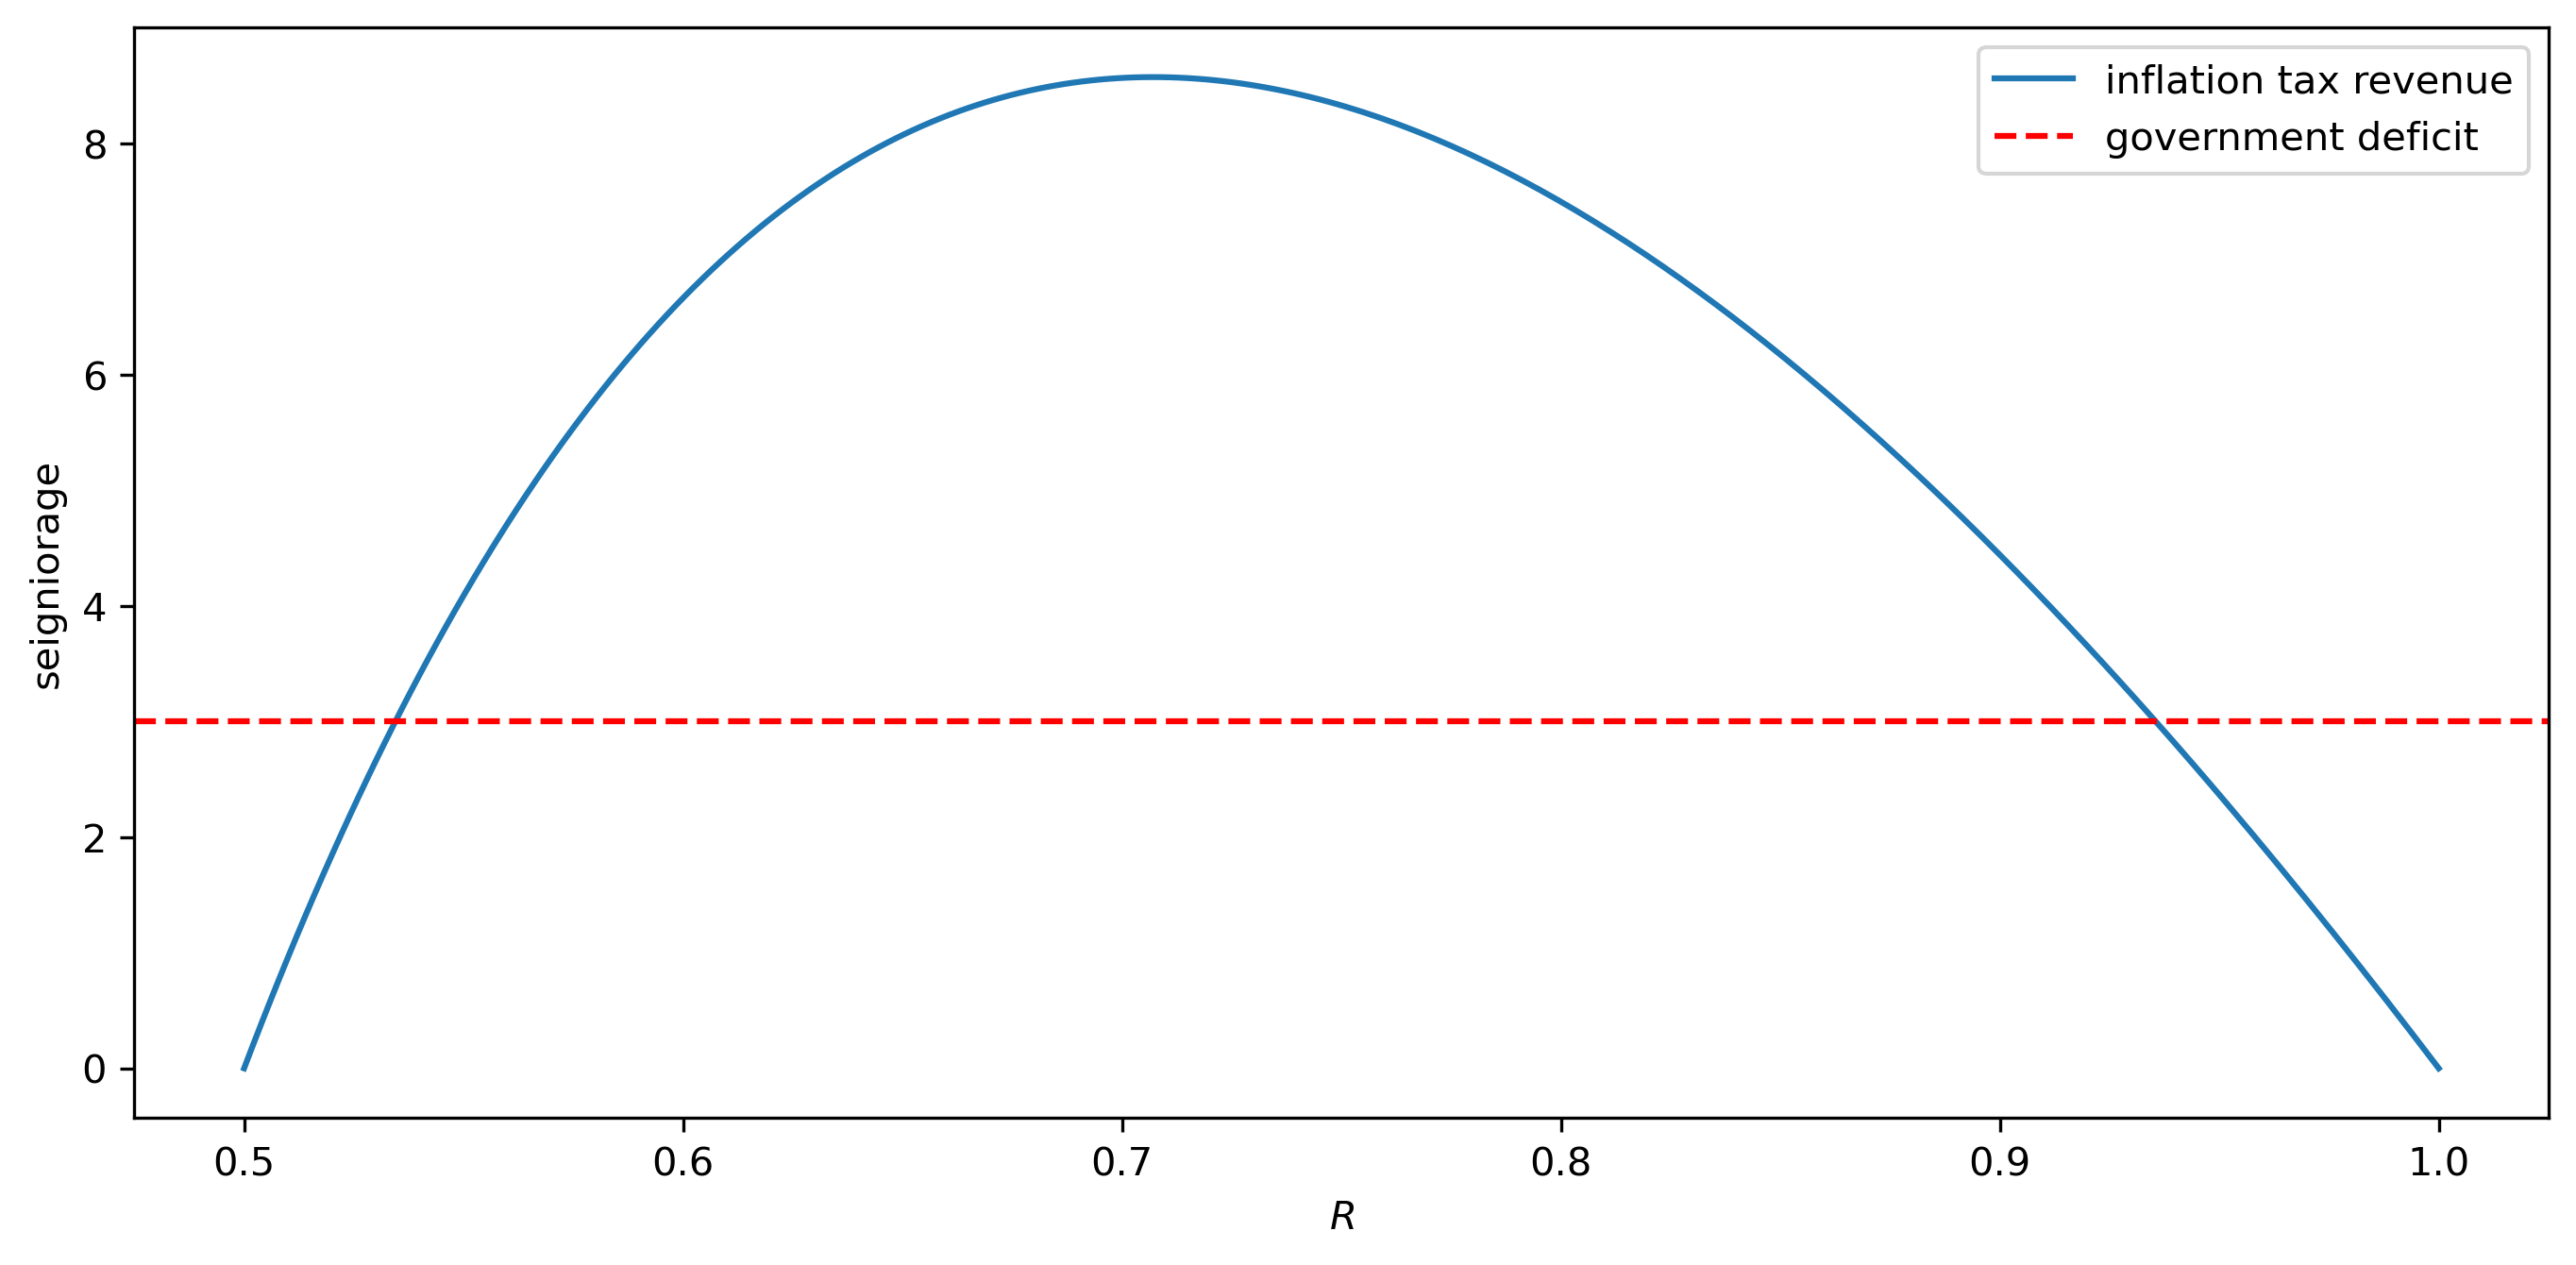

In [4]:
# Generate values for R
R_values = np.linspace(msm.γ2/msm.γ1, 1, 250)

# Calculate the function values
seign_values = seign(R_values, msm)

# Visualize seign_values against R values
fig, ax = plt.subplots(figsize=(11, 5))
plt.plot(R_values, seign_values, label='inflation tax revenue')
plt.axhline(y=msm.g, color='red', linestyle='--', label='government deficit')
plt.xlabel('$R$')
plt.ylabel('seigniorage')

plt.legend()
plt.show()

In [5]:
g1 = seign(msm.R_u, msm)
print(f'R_u, g_u = {msm.R_u:.4f}, {g1:.4f}')

g2 = seign(msm.R_l, msm)
print(f'R_l, g_l = {msm.R_l:.4f}, {g2:.4f}')

R_u, g_u = 0.9356, 3.0000
R_l, g_l = 0.5344, 3.0000


In [6]:
def simulate_system(R0, model, num_steps):
    γ1, γ2, g = model.γ1, model.γ2, model.g

    # Initialize arrays to store results
    b_values = np.empty(num_steps)
    R_values = np.empty(num_steps)

    # Initial values
    b_values[0] = γ1 - γ2/R0
    R_values[0] = 1 / (γ1/γ2 - (1 / γ2) * b_values[0])

    # Iterate over time steps
    for t in range(1, num_steps):
        b_t = b_values[t - 1] * R_values[t - 1] + g
        R_values[t] = 1 / (γ1/γ2 - (1/γ2) * b_t)
        b_values[t] = b_t

    return b_values, R_values

In [7]:
line_params = {'lw': 1.5, 
              'marker': 'o',
              'markersize': 3}

def annotate_graph(ax, model, num_steps):
    for y, label in [(model.R_u, '$R_u$'), (model.R_l, '$R_l$'), 
                     (model.γ2 / model.γ1, r'$\frac{\gamma_2}{\gamma_1}$')]:
        ax.axhline(y=y, color='grey', linestyle='--', lw=1.5, alpha=0.6)
        ax.text(num_steps * 1.02, y, label, verticalalignment='center', 
                color='grey', size=12)

def draw_paths(R0_values, model, line_params, num_steps):

    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    
    # Pre-compute time steps
    time_steps = np.arange(num_steps) 
    
    # Iterate over R_0s and simulate the system 
    for R0 in R0_values:
        b_values, R_values = simulate_system(R0, model, num_steps)
        
        # Plot R_t against time
        axes[0].plot(time_steps, R_values, **line_params)
        
        # Plot b_t against time
        axes[1].plot(time_steps, b_values, **line_params)
        
    # Add line and text annotations to the subgraph 
    annotate_graph(axes[0], model, num_steps)
    
    # Add Labels
    axes[0].set_ylabel('$R_t$')
    axes[1].set_xlabel('timestep')
    axes[1].set_ylabel('$b_t$')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()

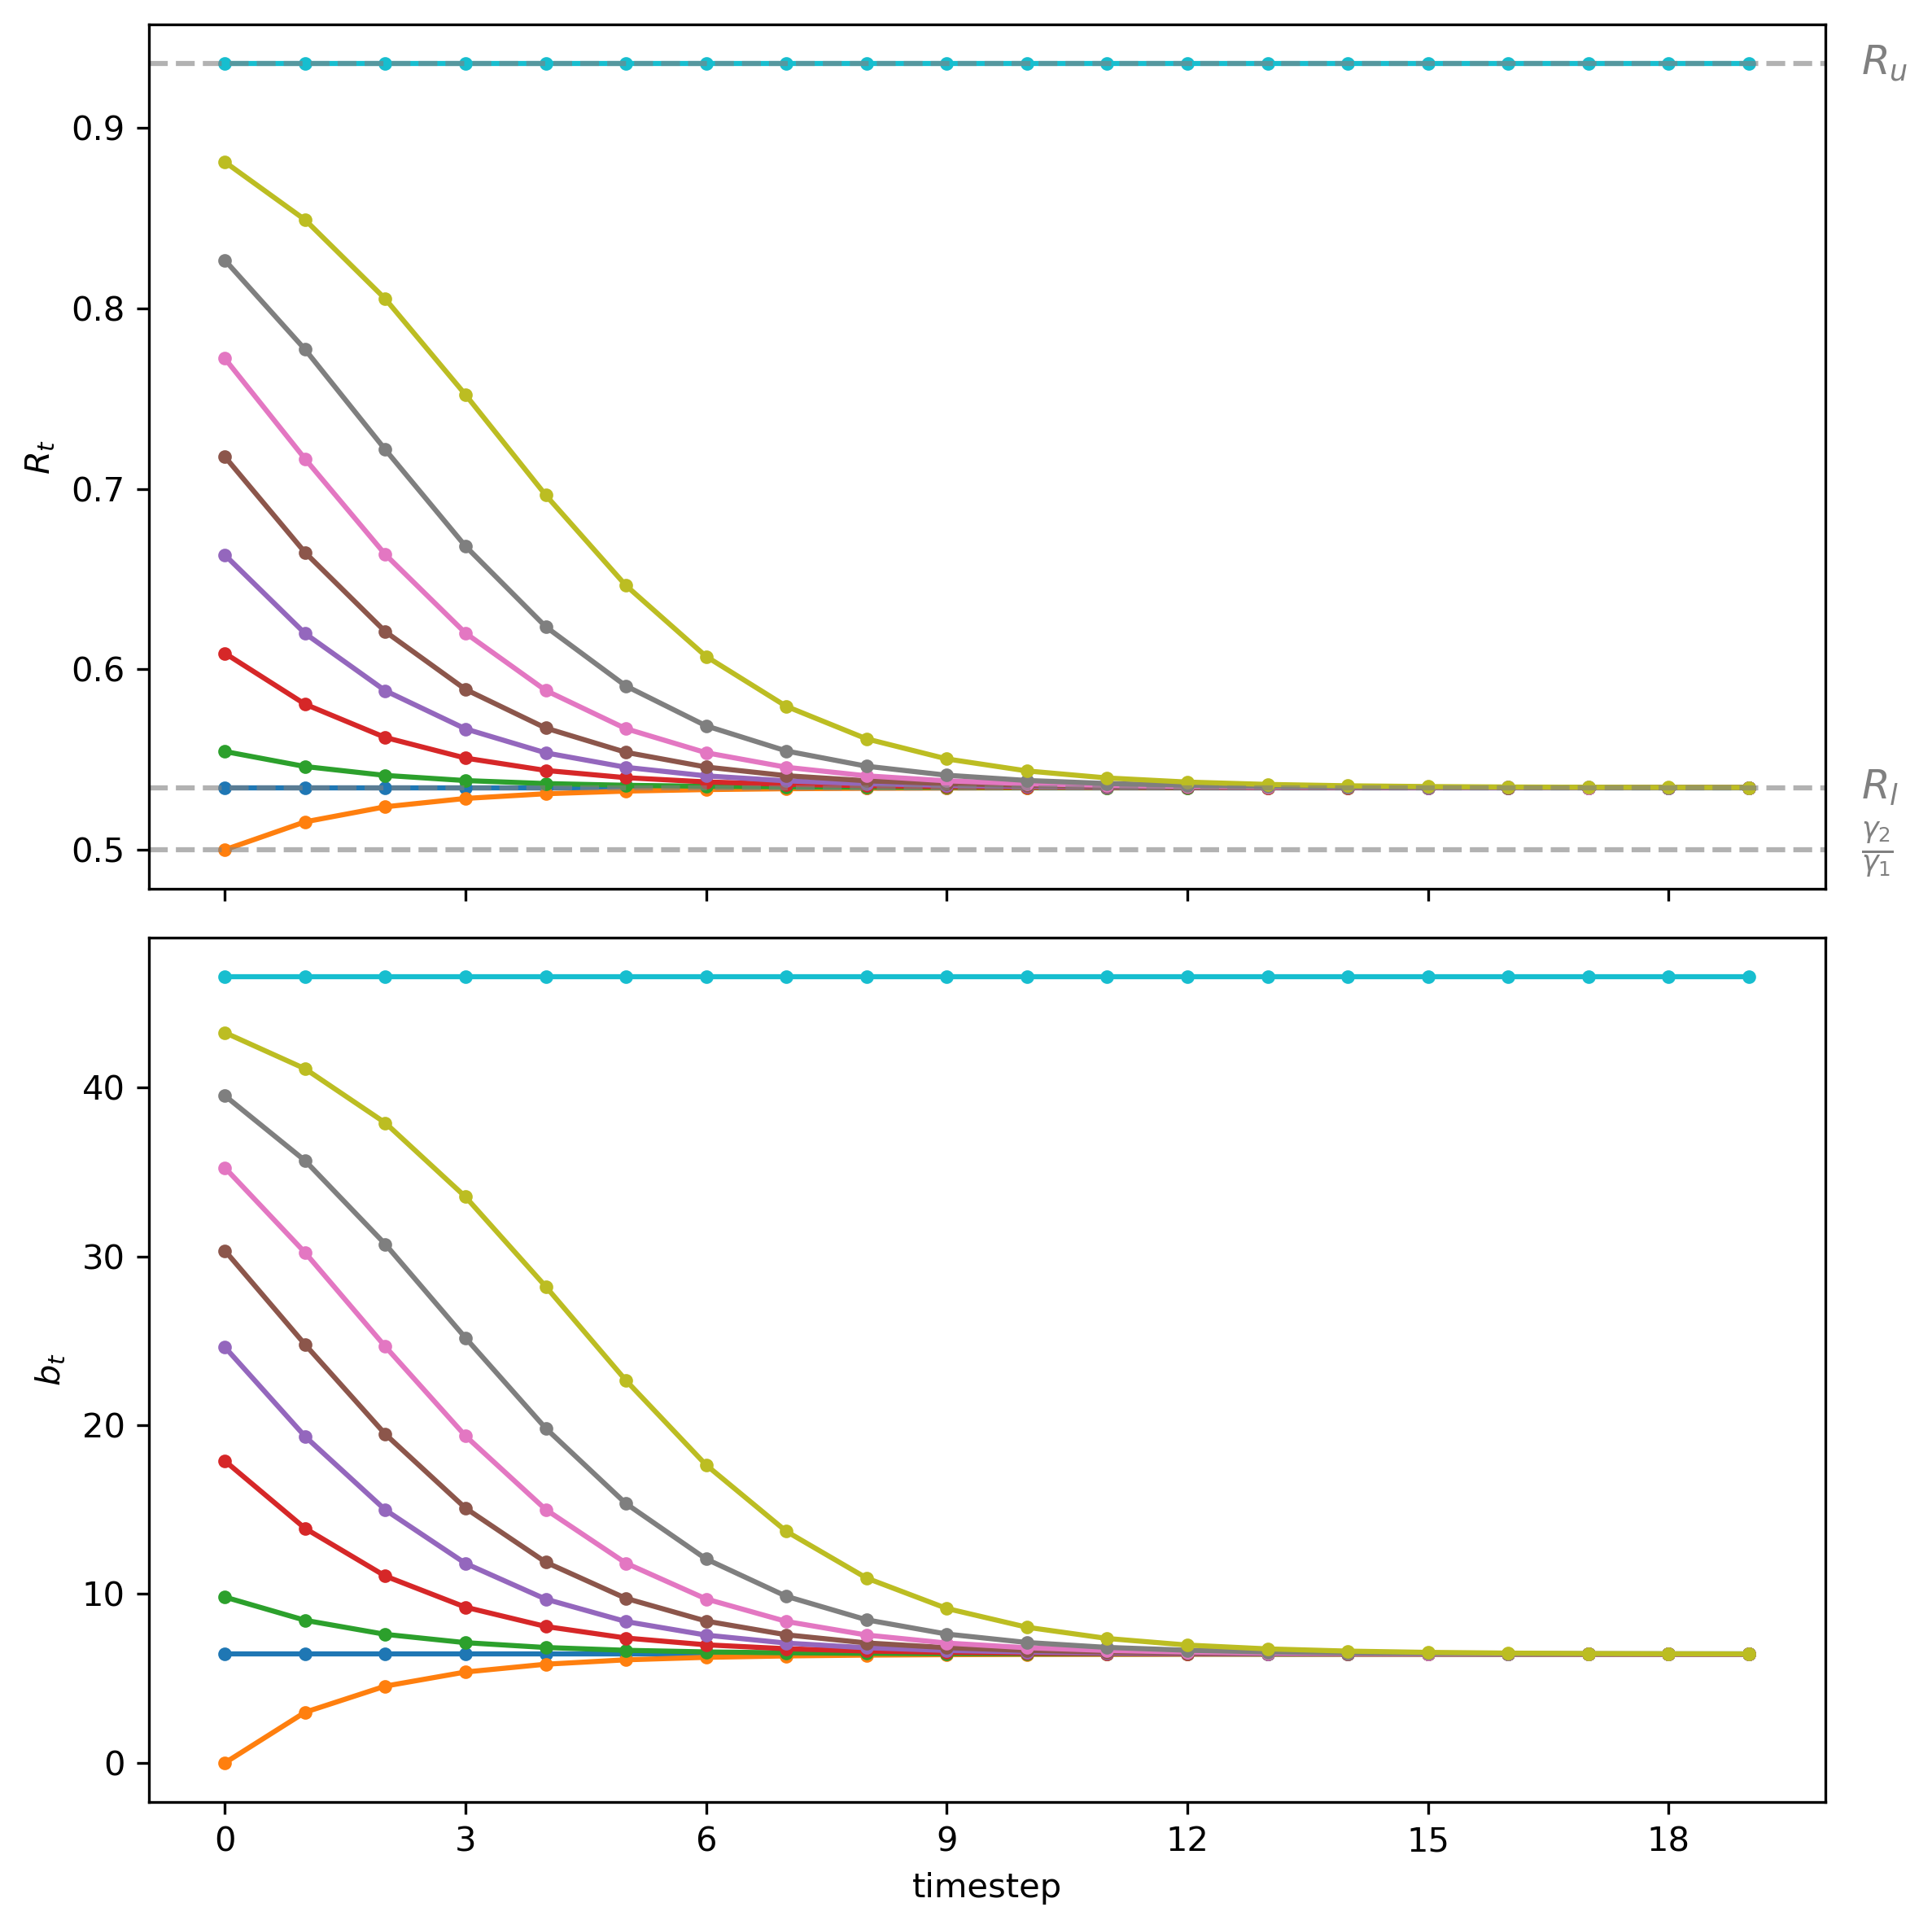

In [8]:
# Create a grid of R_0s
R0s = np.linspace(msm.γ2/msm.γ1, msm.R_u, 9)
R0s = np.append(msm.R_l, R0s)
draw_paths(R0s, msm, line_params, num_steps=20)

In [9]:
H1 = np.array([[1, msm.γ2], 
               [1, 0]])
H2 = np.array([[0, msm.γ1], 
               [1, msm.g]]) 

In [10]:
H = np.linalg.solve(H1, H2)
print('H = \n', H)

H = 
 [[ 1.    3.  ]
 [-0.02  1.94]]


In [11]:
Λ, Q = np.linalg.eig(H)
print('Λ = \n', Λ)
print('Q = \n', Q)

Λ = 
 [1.06887658 1.87112342]
Q = 
 [[-0.99973655 -0.96033288]
 [-0.02295281 -0.27885616]]


In [12]:
R_l = 1 / Λ[0]
R_u = 1 / Λ[1]

print(f'R_l = {R_l:.4f}')
print(f'R_u = {R_u:.4f}')

R_l = 0.9356
R_u = 0.5344


In [13]:
def iterate_H(y_0, H, num_steps):
    Λ, Q = np.linalg.eig(H)
    Q_inv = np.linalg.inv(Q)
    y = np.stack(
        [Q @ np.diag(Λ**t) @ Q_inv @ y_0 for t in range(num_steps)], 1)
    
    return y

In [14]:
p0_bar = (Q[1, 0]/Q[0, 0]) * msm.M0

print(f'p0_bar = {p0_bar:.4f}')

p0_bar = 2.2959


In [15]:
def draw_iterations(p0s, model, line_params, num_steps):

    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    
    # Pre-compute time steps
    time_steps = np.arange(num_steps) 
    
    # Plot the first two y-axes in log scale
    for ax in axes[:2]:
        ax.set_yscale('log')

    # Iterate over p_0s and calculate a series of y_t
    for p0 in p0s:
        y0 = np.array([msm.M0, p0])
        y_series = iterate_H(y0, H, num_steps)
        M, P = y_series[0, :], y_series[1, :]

        # Plot R_t against time
        axes[0].plot(time_steps, M, **line_params)

        # Plot b_t against time
        axes[1].plot(time_steps, P, **line_params)
        
        # Calculate R_t
        R = np.insert(P[:-1] / P[1:], 0, np.NAN)
        axes[2].plot(time_steps, R, **line_params)
        
    # Add line and text annotations to the subgraph 
    annotate_graph(axes[2], model, num_steps)
    
    # Draw labels
    axes[0].set_ylabel('$m_t$')
    axes[1].set_ylabel('$p_t$')
    axes[2].set_ylabel('$R_t$')
    axes[2].set_xlabel('timestep')
    
    # Enforce integar axis label
    axes[2].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

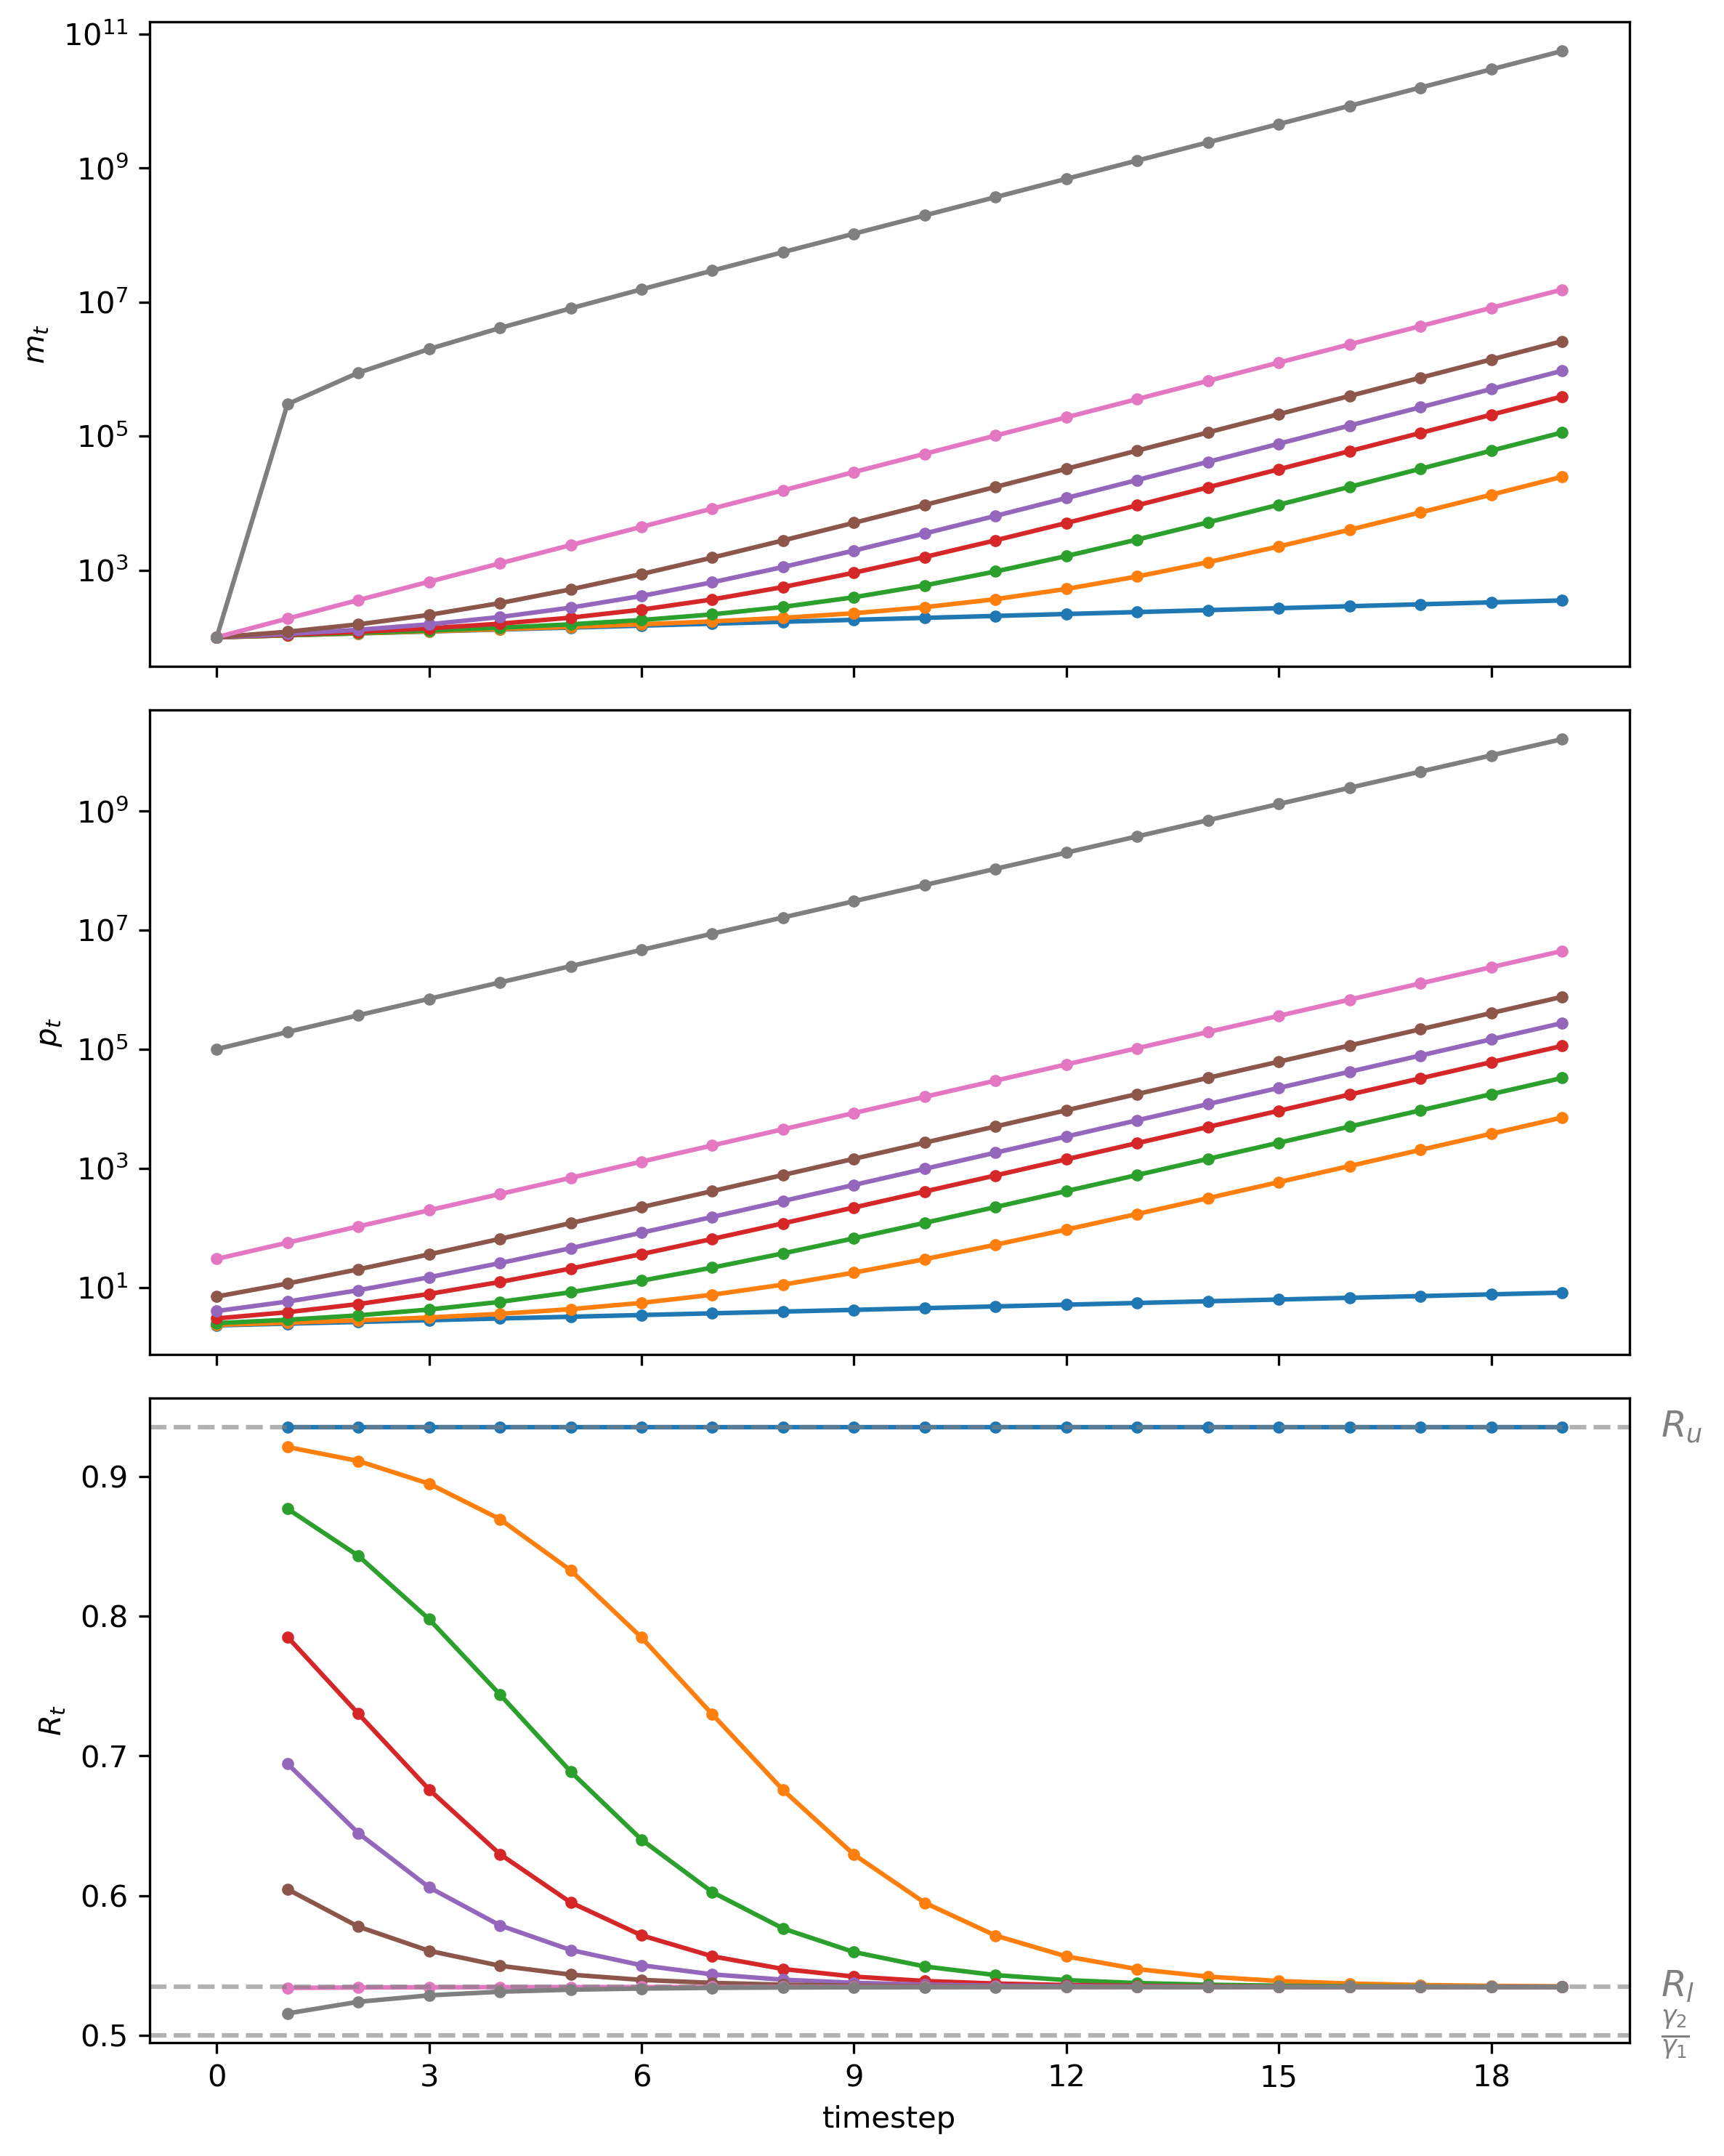

In [16]:
p0s = [p0_bar, 2.34, 2.5, 3, 4, 7, 30, 100_000]

draw_iterations(p0s, msm, line_params, num_steps=20)